<a href="https://colab.research.google.com/github/luca-g97/Master-Thesis/blob/main/Research_Compression_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Environment Setup { display-mode: "form" }

import os
import gdown
import shutil

# Check if we are in Google Colab
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

destination_path = './'

os.makedirs(destination_path, exist_ok=True)

if is_colab:
    print("Running in Colab. Attempting to download data from public source...")
    gdrive_file_id = '1sbx2zZXiMtio7FAehU_8KUii73O-d7-D'
    zip_file_path = './Data.zip'

    try:
        print(f"Downloading Data.zip from Google Drive ID: {gdrive_file_id}...")
        gdown.download(id=gdrive_file_id, output=zip_file_path, quiet=False)
        print("Download complete.")

        print(f"Unzipping {zip_file_path} to {destination_path}...")
        get_ipython().system(f'unzip -q -o {zip_file_path} -d {destination_path}') # -o overwrites without asking
        print("Unzipping complete.")

        os.remove(zip_file_path)
        print(f"Removed {zip_file_path}.")

        source_folder = './TestingArea-Data/Data'
        destination_folder = './' # Current directory

        # Ensure the source folder actually exists
        if not os.path.exists(source_folder):
            print(f"Source folder '{source_folder}' does not exist. Nothing to move.")
        else:
            # List all files and directories in the source folder
            for item_name in os.listdir(source_folder):
                source_item_path = os.path.join(source_folder, item_name)
                destination_item_path = os.path.join(destination_folder, item_name)

                if os.path.exists(destination_item_path):
                    print(f"Warning: '{destination_item_path}' already exists. Skipping '{source_item_path}'.")
                    continue

                try:
                    shutil.move(source_item_path, destination_item_path)
                    #print(f"Moved: '{source_item_path}' -> '{destination_item_path}'")
                except Exception as e:
                    print(f"Error moving '{source_item_path}': {e}")

            if os.path.exists(source_folder) and not os.listdir(source_folder):
                try:
                    shutil.rmtree(source_folder)
                    print(f"Successfully removed empty source folder: '{source_folder}'")
                except Exception as e:
                    print(f"Error removing source folder '{source_folder}': {e}")
            elif os.path.exists(source_folder):
                print(f"Source folder '{source_folder}' is not empty. Did not remove it.")

        print("\nContents of current directory (./):")
        for item in os.listdir(destination_folder):
            if not item.startswith('.') and item != 'Data':
                print(f"  - {item}")

    except Exception as e:
        print(f"An error occurred during download/unzip: {e}")
        print("Please ensure the Google Drive File ID is correct and the file is publicly accessible.")

else:
    print("Not running in Colab. Assuming data is already present locally.")
    if not os.path.exists(destination_path) or not os.listdir(destination_path):
        print(f"Warning: {destination_path} is empty or does not exist. The script might fail.")

Running in Colab. Attempting to download data from public source...


Downloading...
From (original): https://drive.google.com/uc?id=1sbx2zZXiMtio7FAehU_8KUii73O-d7-D
From (redirected): https://drive.google.com/uc?id=1sbx2zZXiMtio7FAehU_8KUii73O-d7-D&confirm=t&uuid=81779b6c-4690-460a-bc90-327d1502154c
To: /content/Data.zip
100%|██████████| 1.12G/1.12G [00:26<00:00, 42.8MB/s]


Download complete.
Unzipping ./Data.zip to ./...
Unzipping complete.
Removed ./Data.zip.
Source folder './TestingArea-Data/Data' is not empty. Did not remove it.

Contents of current directory (./):
  - train.txt
  - identifiedClosestEvalSourcesTrainingSeed0.parquet
  - identifiedClosestEvalSourcesWiki1010.parquet
  - Wiki_SparseArray_0.txt
  - identifiedClosestEvalSourcesTestSeed0.parquet
  - zfp
  - TheVerdict.txt
  - identifiedClosestGeneratedEvalSourcesTrainingSeed0.parquet
  - compression_results.joblib
  - TestingArea-Data
  - identifiedClosestGeneratedEvalSourcesWiki1010.parquet
  - MNIST_SparseArray.txt
  - LookUpGPT2
  - activations_by_layers.npy
  - test.txt
  - compression_results_knn.joblib
  - SZ3
  - Wiki_SparseArray.txt
  - identifiedClosestGeneratedEvalSourcesTestSeed0.parquet
  - training_activations.npy
  - evaluation_activations.npy
  - sample_data


Loading data...
Data loaded successfully.
Actual loaded Train shape: (6, 128, 10000)
Actual loaded Eval shape:  (6, 128, 1)
Analyzing data for Layer 0...
Analyzing data for Layer 1...
Analyzing data for Layer 2...
Analyzing data for Layer 3...
Analyzing data for Layer 4...
Analyzing data for Layer 5...
Analyzing data for Global...


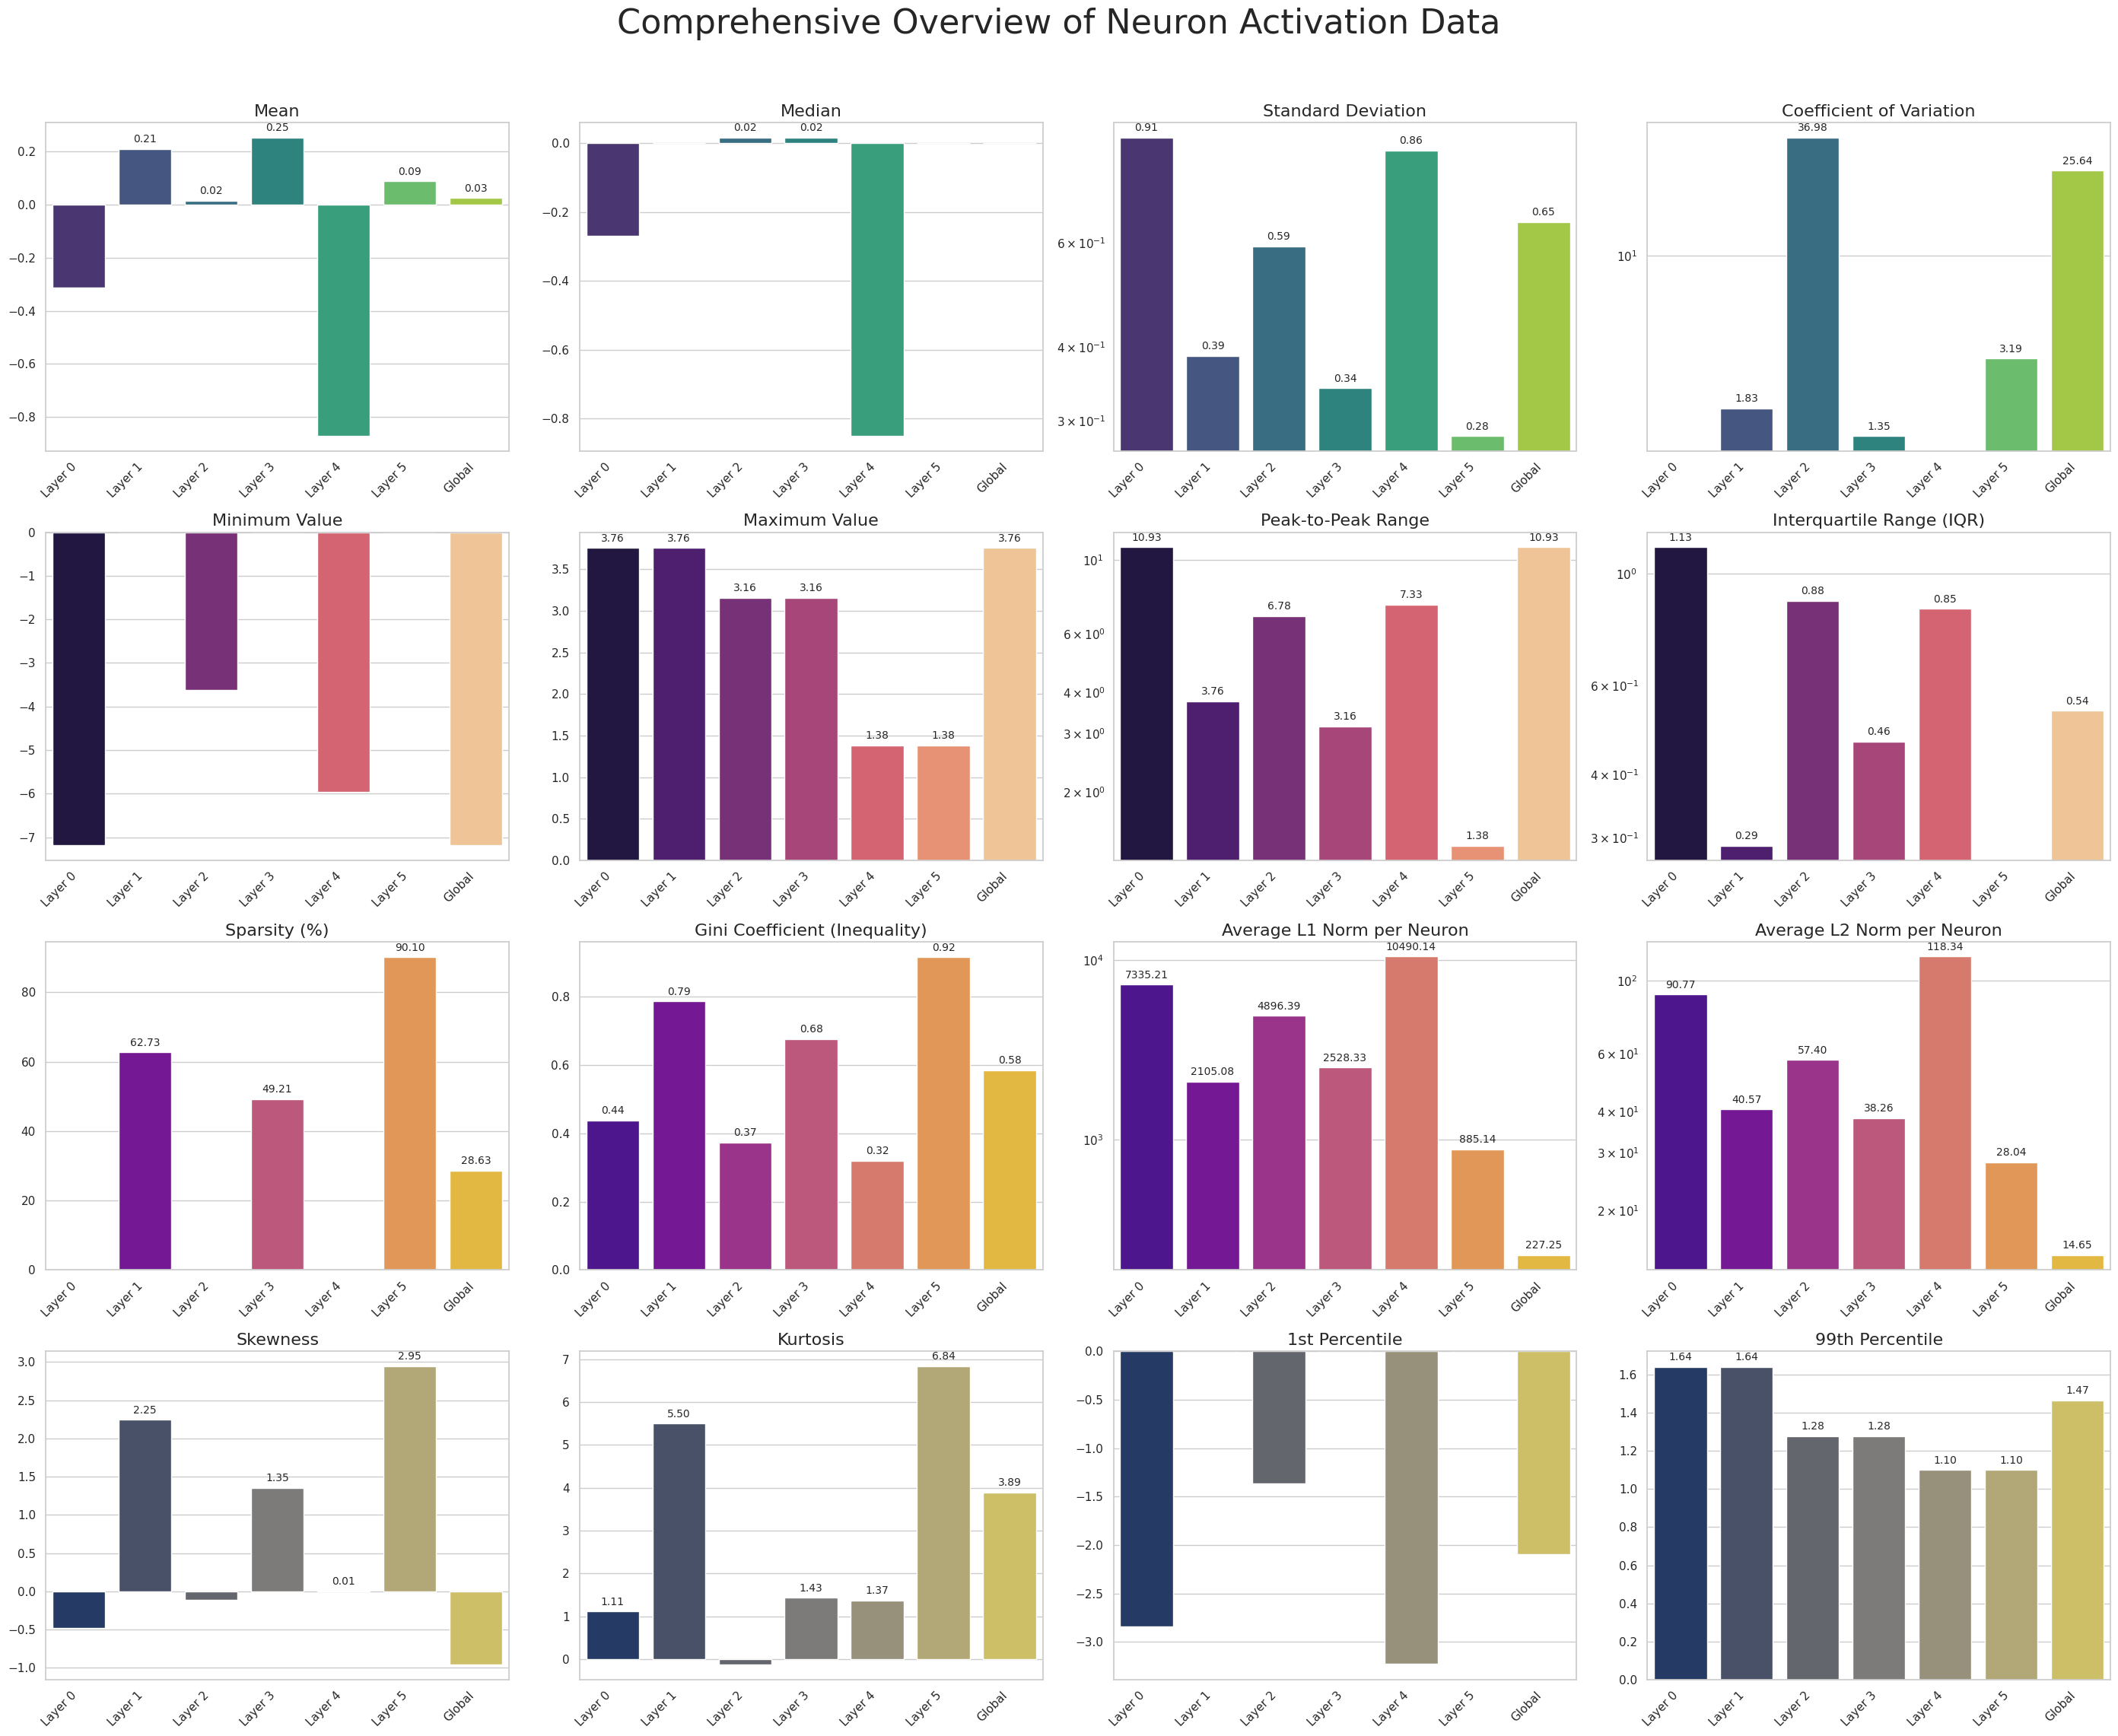

In [ ]:
# @title Neuron Activations Setup & Overview { display-mode: "form" }

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

try:
    print("Loading data...")
    activationsBySources = np.load('training_activations.npy')
    evaluation_activations = np.load('evaluation_activations.npy')
    print("Data loaded successfully.")
    # Example: Check loaded shapes immediately
    print(f"Actual loaded Train shape: {activationsBySources.shape}")
    print(f"Actual loaded Eval shape:  {evaluation_activations.shape}")

    layerSizes = [128, 128, 128, 128, 10, 10]

except FileNotFoundError:
    print("\nError: Data files not found")

# --- 1. Data Analysis Function ---
def analyze_data_characteristics(data, scope_name):
    """
    Calculates a comprehensive set of statistical properties for a given
    dataset of activations.
    """
    print(f"Analyzing data for {scope_name}...")

    # Flatten the data for global statistics
    flat_data = data.flatten()

    # Handle empty data case
    if flat_data.size == 0:
        return {
            'Scope': scope_name, 'Mean': np.nan, 'Median': np.nan, 'Std Dev': np.nan,
            'Min': np.nan, 'Max': np.nan, 'Peak-to-Peak': np.nan, 'Sparsity (%)': np.nan,
            'Skewness': np.nan, 'Kurtosis': np.nan, '1st Percentile': np.nan,
            '99th Percentile': np.nan, 'IQR': np.nan, 'Coeff of Var': np.nan,
            'Avg L2 Norm': np.nan, 'Avg L1 Norm': np.nan, 'Gini Coeff': np.nan
        }

    # Calculate metrics
    sparsity = np.count_nonzero(np.isclose(flat_data, 0)) / flat_data.size * 100

    # Gini Coefficient for sparsity/inequality
    sorted_data = np.sort(np.abs(flat_data))
    n = len(sorted_data)
    cum_data = np.cumsum(sorted_data)
    gini_coeff = (n + 1 - 2 * np.sum(cum_data) / cum_data[-1]) / n if cum_data[-1] != 0 else 0

    # Per-sample norms (axis=0 for per-layer, axis=1 for global)
    per_sample_axis = 0 if data.ndim > 2 else 1

    return {
        'Scope': scope_name,
        'Mean': np.mean(flat_data),
        'Median': np.median(flat_data),
        'Std Dev': np.std(flat_data),
        'Min': np.min(flat_data),
        'Max': np.max(flat_data),
        'Peak-to-Peak': np.ptp(flat_data),
        'Sparsity (%)': sparsity,
        'Skewness': skew(flat_data),
        'Kurtosis': kurtosis(flat_data),
        '1st Percentile': np.percentile(flat_data, 1),
        '99th Percentile': np.percentile(flat_data, 99),
        'IQR': np.percentile(flat_data, 75) - np.percentile(flat_data, 25),
        'Coeff of Var': np.std(flat_data) / (np.mean(flat_data) + 1e-9),
        'Avg L2 Norm': np.mean(np.linalg.norm(data, axis=per_sample_axis)),
        'Avg L1 Norm': np.mean(np.linalg.norm(data, ord=1, axis=per_sample_axis)),
        'Gini Coeff': gini_coeff
    }

# --- 2. Plotting Function ---
def plot_data_overview(df):
    """Generates a multi-panel plot summarizing the data characteristics."""
    fig, axes = plt.subplots(4, 4, figsize=(28, 24))
    fig.suptitle('Comprehensive Overview of Neuron Activation Data', fontsize=32, y=0.98)

    # Helper for annotating bars
    def annotate_bars(ax, is_log=False, fmt="{:.2f}"):
        for p in ax.patches:
            val = p.get_height()
            if not np.isnan(val) and val > 0:
                 ax.annotate(fmt.format(val),
                            (p.get_x() + p.get_width() / 2., val),
                            ha='center', va='center',
                            xytext=(0, 9),
                            textcoords='offset points', fontsize=10)

    # Plotting each metric
    sns.barplot(ax=axes[0, 0], x='Scope', y='Mean', data=df, hue='Scope', palette='viridis', legend=False).set_title('Mean', fontsize=16)
    sns.barplot(ax=axes[0, 1], x='Scope', y='Median', data=df, hue='Scope', palette='viridis', legend=False).set_title('Median', fontsize=16)
    sns.barplot(ax=axes[0, 2], x='Scope', y='Std Dev', data=df, hue='Scope', palette='viridis', legend=False).set_title('Standard Deviation', fontsize=16)
    sns.barplot(ax=axes[0, 3], x='Scope', y='Coeff of Var', data=df, hue='Scope', palette='viridis', legend=False).set_title('Coefficient of Variation', fontsize=16)

    sns.barplot(ax=axes[1, 0], x='Scope', y='Min', data=df, hue='Scope', palette='magma', legend=False).set_title('Minimum Value', fontsize=16)
    sns.barplot(ax=axes[1, 1], x='Scope', y='Max', data=df, hue='Scope', palette='magma', legend=False).set_title('Maximum Value', fontsize=16)
    sns.barplot(ax=axes[1, 2], x='Scope', y='Peak-to-Peak', data=df, hue='Scope', palette='magma', legend=False).set_title('Peak-to-Peak Range', fontsize=16)
    sns.barplot(ax=axes[1, 3], x='Scope', y='IQR', data=df, hue='Scope', palette='magma', legend=False).set_title('Interquartile Range (IQR)', fontsize=16)

    sns.barplot(ax=axes[2, 0], x='Scope', y='Sparsity (%)', data=df, hue='Scope', palette='plasma', legend=False).set_title('Sparsity (%)', fontsize=16)
    sns.barplot(ax=axes[2, 1], x='Scope', y='Gini Coeff', data=df, hue='Scope', palette='plasma', legend=False).set_title('Gini Coefficient (Inequality)', fontsize=16)
    sns.barplot(ax=axes[2, 2], x='Scope', y='Avg L1 Norm', data=df, hue='Scope', palette='plasma', legend=False).set_title('Average L1 Norm per Neuron', fontsize=16)
    sns.barplot(ax=axes[2, 3], x='Scope', y='Avg L2 Norm', data=df, hue='Scope', palette='plasma', legend=False).set_title('Average L2 Norm per Neuron', fontsize=16)

    sns.barplot(ax=axes[3, 0], x='Scope', y='Skewness', data=df, hue='Scope', palette='cividis', legend=False).set_title('Skewness', fontsize=16)
    sns.barplot(ax=axes[3, 1], x='Scope', y='Kurtosis', data=df, hue='Scope', palette='cividis', legend=False).set_title('Kurtosis', fontsize=16)
    sns.barplot(ax=axes[3, 2], x='Scope', y='1st Percentile', data=df, hue='Scope', palette='cividis', legend=False).set_title('1st Percentile', fontsize=16)
    sns.barplot(ax=axes[3, 3], x='Scope', y='99th Percentile', data=df, hue='Scope', palette='cividis', legend=False).set_title('99th Percentile', fontsize=16)

    # Apply log scale and annotations
    for i, ax in enumerate(axes.flatten()):
        ax.set_xlabel('')
        ax.set_ylabel('')
        # CORRECTED: Use plt.setp to set properties on the tick labels themselves
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        annotate_bars(ax)
        if i in [2, 3, 6, 7, 10, 11]: # Indices of plots that benefit from log scale
             ax.set_yscale('log')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# --- 3. Main Orchestrator ---
if __name__ == '__main__':
    all_results = []

    # Analyze each layer
    for i in range(len(layerSizes)):
        layer_data = activationsBySources[i, :layerSizes[i], :]
        results_for_layer = analyze_data_characteristics(layer_data, f'Layer {i}')
        all_results.append(results_for_layer)

    # Analyze the global "super-vector"
    num_samples = activationsBySources.shape[2]
    global_super_vectors = np.array([
        np.concatenate([activationsBySources[l, :layerSizes[l], s] for l in range(len(layerSizes))])
        for s in range(num_samples)
    ])

    global_results = analyze_data_characteristics(global_super_vectors, 'Global')
    all_results.append(global_results)

    # Create and print the final DataFrame
    results_df = pd.DataFrame(all_results)

    #print("\n--- Data Characteristics Summary Table ---")
    #print(results_df.to_string(index=False))

    # Generate the final visual report
    plot_data_overview(results_df)

Preparing global super-vectors to determine data range...
Using data range from actual activations: min=-7.17, max=3.76

Generating metric score distributions across dimensions...


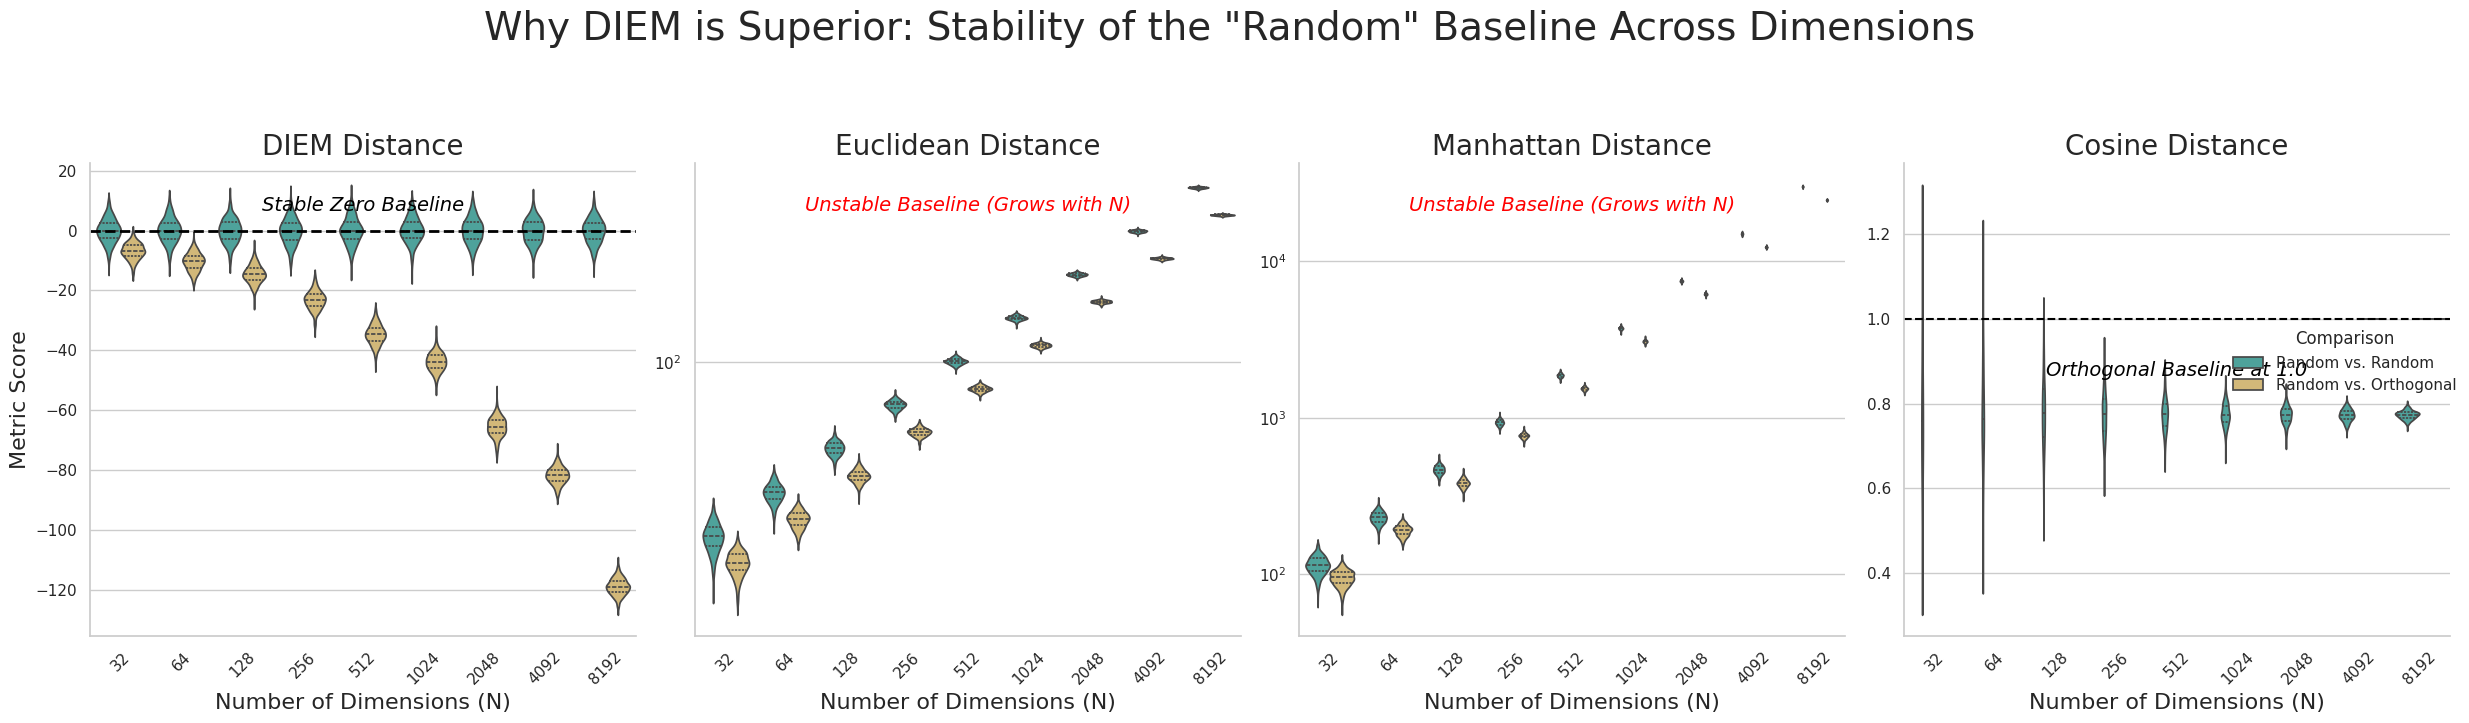

In [ ]:
# @title Dimension Insensitive Euclidean Metric { display-mode: "form" }

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import pandas as pd

# --- 1. Optimized DIEM & Standard Metric Functions ---

def get_metric_distributions(N, maxV, minV, num_iterations=1000):
    """
    Calculates the distributions for DIEM, Euclidean, Manhattan, and Cosine
    distances for two key scenarios: random vs. random and random vs. orthogonal.
    """
    # --- Data Generation ---
    a_vectors = (maxV - minV) * np.random.rand(N, num_iterations) + minV
    b_vectors = (maxV - minV) * np.random.rand(N, num_iterations) + minV

    # Efficiently generate random orthogonal vectors
    c_vectors = np.random.randn(N, num_iterations)
    proj_a_c = np.sum(a_vectors * c_vectors, axis=0) / (np.sum(a_vectors * a_vectors, axis=0) + 1e-9)
    ort_vectors = c_vectors - proj_a_c * a_vectors
    ort_vectors /= (np.linalg.norm(ort_vectors, axis=0) + 1e-9)

    # --- DIEM Statistics ---
    d_rand_raw = np.linalg.norm(a_vectors - b_vectors, axis=0)
    exp_center = np.median(d_rand_raw)
    vard = np.var(d_rand_raw)
    vard = vard if vard > 1e-9 else 1e-9

    # --- Calculate All Metrics ---

    # Scenario 1: Random vs. Random
    diem_rand = (maxV - minV) * (d_rand_raw - exp_center) / vard
    euclidean_rand = d_rand_raw
    manhattan_rand = np.sum(np.abs(a_vectors - b_vectors), axis=0)
    # Cosine similarity calculation, converted to distance
    cos_sim_rand = np.sum(a_vectors * b_vectors, axis=0) / (np.linalg.norm(a_vectors, axis=0) * np.linalg.norm(b_vectors, axis=0) + 1e-9)
    cosine_rand = 1 - cos_sim_rand

    # Scenario 2: Random vs. Orthogonal
    d_orth_raw = np.linalg.norm(a_vectors - ort_vectors, axis=0)
    diem_orth = (maxV - minV) * (d_orth_raw - exp_center) / vard
    euclidean_orth = d_orth_raw
    manhattan_orth = np.sum(np.abs(a_vectors - ort_vectors), axis=0)
    cos_sim_orth = np.sum(a_vectors * ort_vectors, axis=0) / (np.linalg.norm(a_vectors, axis=0) * np.linalg.norm(ort_vectors, axis=0) + 1e-9)
    cosine_orth = 1 - cos_sim_orth

    return {
        'DIEM': (diem_rand, diem_orth),
        'Euclidean': (euclidean_rand, euclidean_orth),
        'Manhattan': (manhattan_rand, manhattan_orth),
        'Cosine': (cosine_rand, cosine_orth)
    }

# --- 2. New Plotting Function for Superiority Analysis ---

def plot_diem_superiority(df):
    """
    Generates a visually pleasing and intuitive plot demonstrating why DIEM is
    superior to other standard distance metrics.
    """
    sns.set_theme(style="whitegrid")

    # Create a faceted grid where each column is a metric
    g = sns.catplot(
        data=df,
        x='Dimensions',
        y='Distance Score',
        hue='Comparison', # This will create the two groups of distributions
        col='Metric',
        kind='violin', # Violin plots are excellent for showing distribution shape
        sharey=False, # Each metric has its own y-axis scale
        palette={'Random vs. Random': '#40B0A6', 'Random vs. Orthogonal': '#E1BE6A'},
        height=7,
        aspect=0.8,
        inner='quartile' # Show quartiles inside the violins
    )

    # --- Customize the Plot for Maximum Clarity ---
    g.fig.suptitle('Why DIEM is Superior: Stability of the "Random" Baseline Across Dimensions', fontsize=28, y=1.03)
    g.set_titles("{col_name} Distance", size=20)
    g.set_axis_labels("Number of Dimensions (N)", "Metric Score", size=16)

    # Add key annotations and reference lines
    for i, ax in enumerate(g.axes.flat):
        ax.tick_params(axis='x', rotation=45)

        # For DIEM, highlight the stable zero baseline
        if i == 0:
            ax.axhline(0, ls='--', color='black', lw=2)
            ax.text(0.5, 0.9, 'Stable Zero Baseline', transform=ax.transAxes,
                    ha='center', fontsize=14, style='italic', color='black')

        # For Euclidean and Manhattan, show that the baseline is unstable
        if i == 1 or i == 2:
            ax.set_yscale('log')
            ax.text(0.5, 0.9, 'Unstable Baseline (Grows with N)', transform=ax.transAxes,
                    ha='center', fontsize=14, style='italic', color='red')

        # For Cosine, highlight its different scale and meaning
        if i == 3:
             ax.axhline(1, ls='--', color='black', lw=1.5)
             ax.text(0.5, 0.55, 'Orthogonal Baseline at 1.0', transform=ax.transAxes,
                    ha='center', fontsize=14, style='italic', color='black')


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 3. Main Orchestrator ---
if __name__ == '__main__':
    # Define the dimensions to test
    dimensions_to_test = [32, 64, 128, 256, 512, 1024, 2048, 4092, 8192]

    # Use the min/max from the actual global data to create realistic synthetic data
    print("Preparing global super-vectors to determine data range...")
    num_samples_train = activationsBySources.shape[2]
    train_super_vectors = np.array([
        np.concatenate([activationsBySources[l, :layerSizes[l], s] for l in range(len(layerSizes))])
        for s in range(num_samples_train)
    ]).T

    minV = train_super_vectors.min()
    maxV = train_super_vectors.max()
    print(f"Using data range from actual activations: min={minV:.2f}, max={maxV:.2f}")

    # Store results for plotting
    all_plot_data = []

    print("\nGenerating metric score distributions across dimensions...")
    for N in dimensions_to_test:
        #print(f"  Processing N = {N}...")

        # Get the distributions for all metrics at this dimension
        distributions = get_metric_distributions(N, maxV, minV, num_iterations=500)

        # Format the data for our DataFrame
        for metric_name, (rand_scores, orth_scores) in distributions.items():
            for score in rand_scores:
                all_plot_data.append({"Dimensions": N, "Distance Score": score,
                                      "Metric": metric_name, "Comparison": "Random vs. Random"})
            for score in orth_scores:
                all_plot_data.append({"Dimensions": N, "Distance Score": score,
                                      "Metric": metric_name, "Comparison": "Random vs. Orthogonal"})

    # Create a DataFrame for easy plotting
    results_df = pd.DataFrame(all_plot_data)

    # Generate the final visual report
    plot_diem_superiority(results_df)

--- Running Full Compression Benchmark for Layer 0 ---
  Benchmarking SOTA Lossless compressors...
  Benchmarking SOTA Near-Lossless compressors...
  Benchmarking custom methods...
--------------------------------------------------
--- Running Full Compression Benchmark for Layer 1 ---
  Benchmarking SOTA Lossless compressors...
  Benchmarking SOTA Near-Lossless compressors...
  Benchmarking custom methods...
--------------------------------------------------
--- Running Full Compression Benchmark for Layer 2 ---
  Benchmarking SOTA Lossless compressors...
  Benchmarking SOTA Near-Lossless compressors...
  Benchmarking custom methods...
--------------------------------------------------
--- Running Full Compression Benchmark for Layer 3 ---
  Benchmarking SOTA Lossless compressors...
  Benchmarking SOTA Near-Lossless compressors...
  Benchmarking custom methods...
--------------------------------------------------
--- Running Full Compression Benchmark for Layer 4 ---
  Benchmarking SO

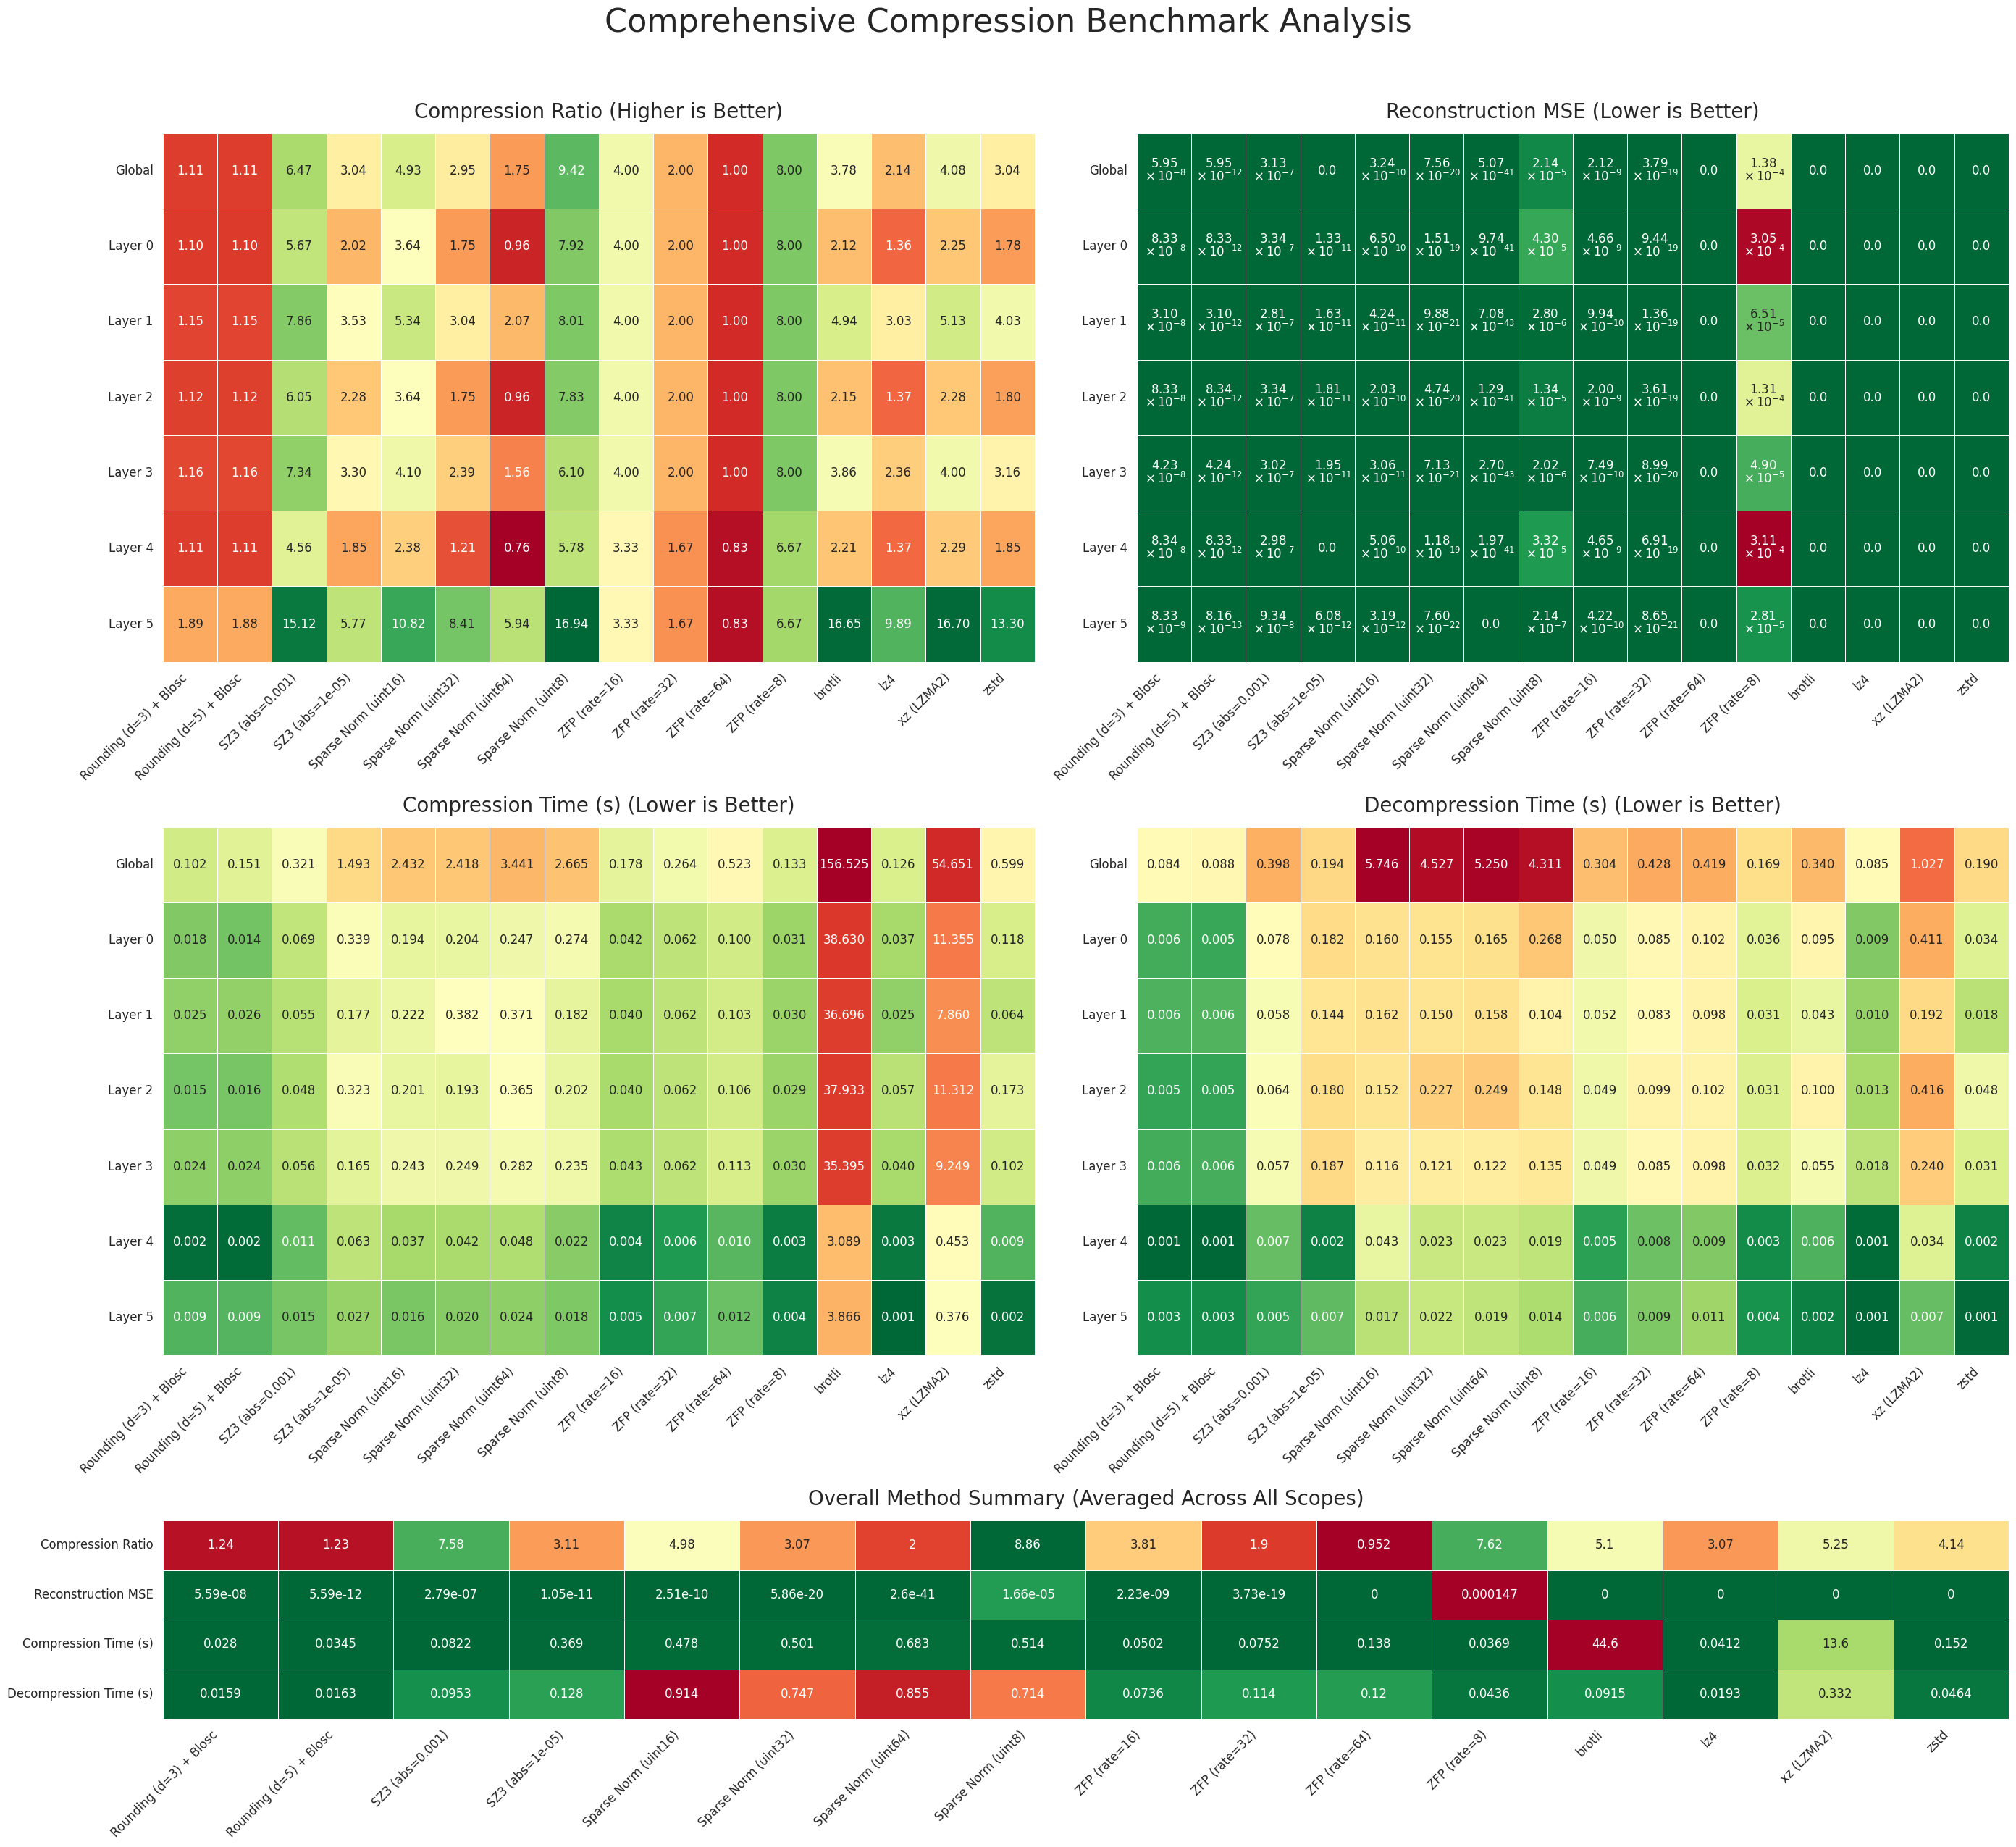

In [ ]:
# @title (Near-)Lossless Compression Test { display-mode: "form" }

import numpy as np
import scipy.sparse as sp
import sys
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import time

# --- Installation of necessary libraries ---
# This is a more robust installation block for Colab environments.
# It cleans up old directories to ensure a fresh build and installs all dependencies.
#print("Installing system-level dependencies for compression libraries...")
!apt-get install -y build-essential cmake liblz4-dev libblosc-dev > /dev/null 2>&1

# Clean up previous builds to ensure a fresh start
!rm -rf zfp SZ3

#print("Building zfp from source...")
!git clone https://github.com/LLNL/zfp.git > /dev/null 2>&1
!cd zfp && mkdir -p build && cd build && cmake .. > /dev/null 2>&1 && make -j > /dev/null 2>&1 && sudo make install > /dev/null 2>&1

#print("Building SZ3 from source...")
!git clone https://github.com/szcompressor/SZ3.git > /dev/null 2>&1
!cd SZ3 && mkdir -p build && cd build && cmake .. > /dev/null 2>&1 && make -j > /dev/null 2>&1 && sudo make install > /dev/null 2>&1

!ldconfig > /dev/null 2>&1
#print("Installing Python packages...")
# CORRECTED: The pysz script is not a package, so we add its path to sys.path instead of using pip.
pysz_path = os.path.abspath('SZ3/tools/pysz')
if pysz_path not in sys.path:
    sys.path.insert(0, pysz_path)

!python3 -m pip install -q pyarrow zstandard lz4 brotli blosc zfpy
#print("Installation complete.")


# --- Import SOTA Compressors with Error Handling ---
sota_lossless_compressors = {}
sota_lossless_decompressors = {}
blosc, zfpy, pysz_compressor = None, None, None

try:
    import zstandard as zstd
    sota_lossless_compressors['zstd'] = zstd.compress
    sota_lossless_decompressors['zstd'] = zstd.decompress
    #print("Successfully imported zstandard.")
except ImportError:
    print("Warning: zstandard not found. Skipping zstd benchmark.")

try:
    import lz4.frame
    sota_lossless_compressors['lz4'] = lz4.frame.compress
    sota_lossless_decompressors['lz4'] = lz4.frame.decompress
    #print("Successfully imported lz4.")
except ImportError:
    print("Warning: lz4 not found. Skipping lz4 benchmark.")

try:
    import brotli
    sota_lossless_compressors['brotli'] = brotli.compress
    sota_lossless_decompressors['brotli'] = brotli.decompress
    #print("Successfully imported brotli.")
except ImportError:
    print("Warning: brotli not found. Skipping brotli benchmark.")

try:
    import lzma
    sota_lossless_compressors['xz (LZMA2)'] = lzma.compress
    sota_lossless_decompressors['xz (LZMA2)'] = lzma.decompress
    #print("Successfully imported lzma.")
except ImportError:
    print("Warning: lzma not found. Skipping xz benchmark.")

try:
    import blosc
    #print("Successfully imported blosc.")
except ImportError:
    print("Warning: blosc not found. Skipping blosc benchmark.")

try:
    import zfpy
    #print("Successfully imported zfpy.")
except ImportError:
    print("Warning: zfpy not found. Skipping zfpy benchmark.")

try:
    from pysz import SZ
    pysz_compressor = SZ()
    #print("Successfully imported pysz (for SZ3).")
except ImportError:
    pysz_compressor = None
    print("Warning: pysz not found. Skipping SZ3 benchmark.")


# Assume 'activationsBySources' and 'layerSizes' are loaded from your previous snippet.

# --- Core Logic Functions (Upgraded for High Precision) ---
def normalize_to_integer_sparse(sparse_data_coo, min_val, max_val, dtype=np.uint32):
    """Normalizes a sparse float COO matrix to a sparse integer COO matrix of a specified dtype."""
    iinfo = np.iinfo(dtype)
    min_int, max_int = iinfo.min, iinfo.max

    if min_val == max_val:
        mid_int_val = min_int + (max_int - min_int) // 2
        return sp.coo_matrix((np.full_like(sparse_data_coo.data, mid_int_val, dtype=dtype),
                               (sparse_data_coo.row, sparse_data_coo.col)), shape=sparse_data_coo.shape)

    # Use longdouble for higher precision to avoid overflow with uint64
    min_val_ld = np.longdouble(min_val)
    max_val_ld = np.longdouble(max_val)
    data_ld = sparse_data_coo.data.astype(np.longdouble)

    scale_factor = (np.longdouble(max_int) - np.longdouble(min_int)) / (max_val_ld - min_val_ld)
    shift_factor = np.longdouble(min_int) - min_val_ld * scale_factor

    normalized_data = data_ld * scale_factor + shift_factor
    normalized_data = np.clip(np.round(normalized_data), min_int, max_int).astype(dtype)

    return sp.coo_matrix((normalized_data, (sparse_data_coo.row, sparse_data_coo.col)), shape=sparse_data_coo.shape)

def reconstruct_from_normalized(sparse_int_coo, min_val, max_val, dtype=np.uint32):
    """Reconstructs a sparse float COO matrix from a sparse integer COO matrix."""
    iinfo = np.iinfo(dtype)
    min_int, max_int = iinfo.min, iinfo.max

    if min_val == max_val:
        reconstructed_data = np.full_like(sparse_int_coo.data, min_val, dtype=float)
        return sp.coo_matrix((reconstructed_data, (sparse_int_coo.row, sparse_int_coo.col)), shape=sparse_int_coo.shape)

    # Use longdouble for higher precision
    min_val_ld = np.longdouble(min_val)
    max_val_ld = np.longdouble(max_val)
    data_ld = sparse_int_coo.astype(np.longdouble).data

    scale_factor = (max_val_ld - min_val_ld) / (np.longdouble(max_int) - np.longdouble(min_int))
    shift_factor = min_val_ld - np.longdouble(min_int) * scale_factor

    reconstructed_data = data_ld * scale_factor + shift_factor

    return sp.coo_matrix((reconstructed_data.astype(np.float64), (sparse_int_coo.row, sparse_int_coo.col)), shape=sparse_int_coo.shape)

# --- Data Preparation for Global Analysis ---
def create_global_super_vectors(activations, layer_sizes):
    num_samples = activations.shape[2]
    all_samples_global = [np.concatenate([activations[l, :layer_sizes[l], s] for l in range(len(layer_sizes))]) for s in range(num_samples)]
    return np.array(all_samples_global)


# --- Full Compression & Accuracy Analysis Workflow ---
def run_compression_benchmark(original_data, scope_name, dtypes_to_test):
    print(f"--- Running Full Compression Benchmark for {scope_name} ---")
    scope_results = []

    original_data = original_data.astype(np.float64)
    original_size_bytes = original_data.nbytes

    # --- 1. Benchmark SOTA Lossless Compressors ---
    print("  Benchmarking SOTA Lossless compressors...")
    temp_bin_file = 'temp_data.bin'
    original_data.tofile(temp_bin_file)
    with open(temp_bin_file, 'rb') as f:
        raw_bytes = f.read()

    for name, func in sota_lossless_compressors.items():
        start_time = time.time()
        compressed_bytes = func(raw_bytes)
        compress_time = time.time() - start_time

        start_time = time.time()
        decompressed_bytes = sota_lossless_decompressors[name](compressed_bytes)
        decompress_time = time.time() - start_time

        scope_results.append({
            'Layer': scope_name, 'Method': name,
            'Compression Ratio': original_size_bytes / len(compressed_bytes),
            'Reconstruction MSE': 0.0,
            'Compression Time (s)': compress_time,
            'Decompression Time (s)': decompress_time
        })
    os.remove(temp_bin_file)

    # --- 2. Benchmark SOTA Near-Lossless Compressors ---
    print("  Benchmarking SOTA Near-Lossless compressors...")
    if zfpy:
        for rate in [8, 16, 32, 64]: # Bits per value
            start_time = time.time()
            compressed_zfp = zfpy.compress_numpy(original_data, rate=rate)
            compress_time = time.time() - start_time
            start_time = time.time()
            reconstructed_zfp = zfpy.decompress_numpy(compressed_zfp)
            decompress_time = time.time() - start_time
            scope_results.append({
                'Layer': scope_name, 'Method': f'ZFP (rate={rate})',
                'Compression Ratio': original_size_bytes / len(compressed_zfp),
                'Reconstruction MSE': np.mean(np.square(original_data - reconstructed_zfp)),
                'Compression Time (s)': compress_time, 'Decompression Time (s)': decompress_time
            })

    if pysz_compressor:
        for error_bound in [1e-3, 1e-5]:
            start_time = time.time()
            compressed_sz, _ = pysz_compressor.compress(original_data, eb_mode=0, eb_abs=error_bound, eb_rel=0, eb_pwr=0)
            compress_time = time.time() - start_time
            start_time = time.time()
            reconstructed_sz = pysz_compressor.decompress(compressed_sz, original_data.shape, original_data.dtype)
            decompress_time = time.time() - start_time
            scope_results.append({
                'Layer': scope_name, 'Method': f'SZ3 (abs={error_bound})',
                'Compression Ratio': original_size_bytes / len(compressed_sz),
                'Reconstruction MSE': np.mean(np.square(original_data - reconstructed_sz)),
                'Compression Time (s)': compress_time, 'Decompression Time (s)': decompress_time
            })

    if blosc:
        for decimals in [3, 5]:
            start_time = time.time()
            rounded_data = np.round(original_data, decimals=decimals)
            compress_time_round = time.time() - start_time

            start_time_blosc = time.time()
            # CORRECTED: Use blosc.BITSHUFFLE instead of blosc.BIT
            compressed_bytes = blosc.compress(rounded_data, typesize=8, clevel=9, shuffle=blosc.BITSHUFFLE)
            compress_time = compress_time_round + (time.time() - start_time_blosc)

            start_time = time.time()
            decompressed_bytes = blosc.decompress(compressed_bytes)
            reconstructed_array = np.frombuffer(decompressed_bytes, dtype=rounded_data.dtype).reshape(original_data.shape)
            decompress_time = time.time() - start_time

            scope_results.append({
                'Layer': scope_name, 'Method': f'Rounding (d={decimals}) + Blosc',
                'Compression Ratio': original_size_bytes / len(compressed_bytes),
                'Reconstruction MSE': np.mean(np.square(original_data - reconstructed_array)),
                'Compression Time (s)': compress_time, 'Decompression Time (s)': decompress_time
            })


    # --- 3. Benchmark Custom "Sparse Normalized" Method ---
    num_samples = original_data.shape[1] if original_data.ndim > 2 else original_data.shape[0]
    num_neurons = original_data.shape[0] if original_data.ndim > 2 else original_data.shape[1]

    print(f"  Benchmarking custom methods...")
    for dtype in dtypes_to_test:
        dtype_name = np.dtype(dtype).name
        method_name = f'Sparse Norm ({dtype_name})'

        start_time_compress = time.time()
        all_samples_data = []
        for i in range(num_samples):
            sample_vector = original_data[:, i] if original_data.ndim > 2 else original_data[i, :]
            sparse_sample = sp.coo_matrix(sample_vector.reshape(-1, 1))
            sample_info = {'sample_id': i}
            if sparse_sample.nnz > 0:
                min_v, max_v = sparse_sample.min(), sparse_sample.max()
                sparse_int_sample = normalize_to_integer_sparse(sparse_sample, min_v, max_v, dtype=dtype)
                sample_info.update({'min_val': np.float32(min_v), 'max_val': np.float32(max_v),
                                    'sparse_indices': sparse_int_sample.row, 'sparse_values': sparse_int_sample.data})
            else:
                sample_info.update({'min_val': 0.0, 'max_val': 0.0, 'sparse_indices': np.array([], dtype=int),
                                    'sparse_values': np.array([], dtype=dtype)})
            all_samples_data.append(sample_info)
        df = pd.DataFrame(all_samples_data)
        table = pa.Table.from_pandas(df)
        temp_filepath = f'temp_{scope_name}_{dtype_name}.parquet'
        pq.write_table(table, temp_filepath, compression='zstd')
        compress_time = time.time() - start_time_compress
        compressed_size_bytes = os.path.getsize(temp_filepath)

        start_time_decompress = time.time()
        read_table = pq.read_table(temp_filepath)
        read_df = read_table.to_pandas()
        reconstructed_data = []
        for i, row in read_df.iterrows():
            if len(row['sparse_values']) > 0:
                reconstructed_sparse = reconstruct_from_normalized(
                    sp.coo_matrix((row['sparse_values'], (row['sparse_indices'], np.zeros_like(row['sparse_indices']))),
                                  shape=(num_neurons, 1)), row['min_val'], row['max_val'], dtype=dtype)
                reconstructed_data.append(reconstructed_sparse.toarray())
            else:
                reconstructed_data.append(np.zeros((num_neurons, 1)))
        reconstructed_matrix = np.hstack(reconstructed_data)
        decompress_time = time.time() - start_time_decompress

        os.remove(temp_filepath)

        original_matrix = original_data if original_data.ndim > 2 else original_data.T
        total_mse = np.mean(np.square(original_matrix - reconstructed_matrix))

        scope_results.append({
            'Layer': scope_name, 'Method': method_name,
            'Compression Ratio': original_size_bytes / compressed_size_bytes,
            'Reconstruction MSE': total_mse,
            'Compression Time (s)': compress_time,
            'Decompression Time (s)': decompress_time
        })

    print("-" * 50)
    return scope_results

# --- Plotting Function for the Final Report ---
def plot_final_heatmap_report(df):
    # --- 1. Create Pivot Tables for Each Metric ---
    try:
        pivot_ratio = df.pivot_table(index='Layer', columns='Method', values='Compression Ratio')
        pivot_mse = df.pivot_table(index='Layer', columns='Method', values='Reconstruction MSE')
        pivot_ctime = df.pivot_table(index='Layer', columns='Method', values='Compression Time (s)')
        pivot_dtime = df.pivot_table(index='Layer', columns='Method', values='Decompression Time (s)')
    except Exception as e:
        print(f"Could not create pivot tables. Error: {e}")
        return

    # --- 2. Create Custom, Readable Annotations for the MSE Plot ---
    annot_mse = pd.DataFrame(index=pivot_mse.index, columns=pivot_mse.columns, dtype=str)
    for r_idx, row in pivot_mse.iterrows():
        for c_idx, val in row.items():
            if val == 0.0:
                annot_mse.loc[r_idx, c_idx] = "0.0"
            else:
                exponent = int(np.floor(np.log10(abs(val))))
                mantissa = val / (10**exponent)
                annot_mse.loc[r_idx, c_idx] = f'$\\substack{{{mantissa:.2f} \\\\ \\times 10^{{{exponent}}}}}$'

    # --- 2. Create a Summary Table ---
    summary_df = df.groupby('Method')[['Compression Ratio', 'Reconstruction MSE', 'Compression Time (s)', 'Decompression Time (s)']].mean()

    # --- 3. Plotting ---
    fig = plt.figure(figsize=(28, 26))
    gs = fig.add_gridspec(3, 2, height_ratios=[4, 4, 1.5]) # Increased bottom ratio for summary
    fig.suptitle('Comprehensive Compression Benchmark Analysis', fontsize=32, y=0.98)

    ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
    ax3, ax4 = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])
    ax_summary = fig.add_subplot(gs[2, :])

    # --- Helper function for plotting heatmaps with intuitive colors ---
    def plot_intuitive_heatmap(ax, pivot_table, title, fmt, annotToUse=True, lower_is_better=False):
        # SymLogNorm is great for data spanning orders of magnitude
        # We center the color map on the median value
        center_val = np.median(pivot_table.values)
        norm = SymLogNorm(linthresh=0.01, vmin=pivot_table.min().min(), vmax=pivot_table.max().max(), base=10)

        # Green is good (RdYlGn), Red is good (RdYlGn_r)
        cmap = "RdYlGn_r" if lower_is_better else "RdYlGn"

        sns.heatmap(pivot_table, ax=ax, annot=annotToUse, fmt=fmt, cmap=cmap, linewidths=.5, norm=norm, cbar=False)
        ax.set_title(title, fontsize=20, pad=15)
        ax.set_xlabel(''), ax.set_ylabel('')

    # --- Plot 1: Compression Ratio ---
    plot_intuitive_heatmap(ax1, pivot_ratio, 'Compression Ratio (Higher is Better)', '.2f', lower_is_better=False)
    ax1.set_ylabel('', fontsize=16)

    # --- Plot 2: Reconstruction MSE ---
    plot_intuitive_heatmap(ax2, pivot_mse, 'Reconstruction MSE (Lower is Better)', 's', annotToUse=annot_mse, lower_is_better=True)

    # --- Plot 3: Compression Time ---
    plot_intuitive_heatmap(ax3, pivot_ctime, 'Compression Time (s) (Lower is Better)', '.3f', lower_is_better=True)
    ax3.set_xlabel('', fontsize=16)
    ax3.set_ylabel('', fontsize=16)

    # --- Plot 4: Decompression Time ---
    plot_intuitive_heatmap(ax4, pivot_dtime, 'Decompression Time (s) (Lower is Better)', '.3f', lower_is_better=True)
    ax4.set_xlabel('', fontsize=16)

    # --- Bottom Summary Table with Intuitive Colors ---
    # Normalize each row (metric) to determine color
    summary_norm = summary_df.T.copy()
    summary_norm.loc['Compression Ratio'] = normalize_for_color(summary_df['Compression Ratio'].to_frame().T, lower_is_better=False).iloc[0]
    summary_norm.loc['Reconstruction MSE'] = normalize_for_color(summary_df['Reconstruction MSE'].to_frame().T, lower_is_better=True).iloc[0]
    summary_norm.loc['Compression Time (s)'] = normalize_for_color(summary_df['Compression Time (s)'].to_frame().T, lower_is_better=True).iloc[0]
    summary_norm.loc['Decompression Time (s)'] = normalize_for_color(summary_df['Decompression Time (s)'].to_frame().T, lower_is_better=True).iloc[0]

    sns.heatmap(summary_norm, ax=ax_summary, annot=summary_df.T, fmt='.3g', cmap='RdYlGn', cbar=False, linewidths=.5)
    ax_summary.set_title('Overall Method Summary (Averaged Across All Scopes)', fontsize=20, pad=15)
    ax_summary.set_xlabel(''), ax_summary.set_ylabel('', fontsize=16)

    # Rotate all x-axis labels for readability
    for ax in [ax1, ax2, ax3, ax4, ax_summary]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        plt.setp(ax.get_yticklabels(), rotation=0, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# You still need the helper function for the summary table normalization
def normalize_for_color(pivot_table, lower_is_better=False):
    min_val, max_val = pivot_table.min().min(), pivot_table.max().max()
    if (max_val - min_val) < 1e-9:
        return pd.DataFrame(0.5, index=pivot_table.index, columns=pivot_table.columns)
    normalized = (pivot_table - min_val) / (max_val - min_val)
    return 1 - normalized if lower_is_better else normalized

# --- Main Execution ---
if __name__ == '__main__':
    dtypes_to_test = [np.uint8, np.uint16, np.uint32, np.uint64]
    all_results = []

    # Run per-layer analysis
    for i in range(len(layerSizes)):
        layer_data = activationsBySources[i, :layerSizes[i], :]
        results_for_layer = run_compression_benchmark(layer_data, f'Layer {i}', dtypes_to_test)
        all_results.extend(results_for_layer)

    # Run global analysis
    print("Preparing global super-vectors...")
    train_super_vectors = create_global_super_vectors(activationsBySources, layerSizes)
    global_results = run_compression_benchmark(train_super_vectors, 'Global', dtypes_to_test)
    all_results.extend(global_results)

    results_df_compression = pd.DataFrame(all_results)

    #print("\n--- Final Summary Table ---")
    #pivot_df = results_df_compression.pivot_table(index='Layer', columns='Method', values='Compression Ratio').round(2)
    #print(pivot_df)

    plot_final_heatmap_report(results_df_compression)

In [ ]:
# @title Storage of the results { display-mode: "form" }

import joblib

joblib.dump(all_results, 'compression_results.joblib')
print("Results successfully saved to compression_results.joblib")

# Load the data from the file
resultsArray = joblib.load('compression_results.joblib')

# You can now use this loaded variable for analysis or visualization
print("Successfully loaded results.")
print(f"Loaded data for {len(all_results)} compression methods.")

Results successfully saved to compression_results.joblib
Successfully loaded results.
Loaded data for 112 compression methods.


In [ ]:
K = 10
EVAL_SAMPLE_TO_CHECK = 0

Successfully imported zfpy.
Successfully imported pysz (for SZ3).
--- Generating reconstructed datasets for Layer 0 ---
--- Generating reconstructed datasets for Eval Sample Layer 0 ---
--- Generating reconstructed datasets for Layer 1 ---
--- Generating reconstructed datasets for Eval Sample Layer 1 ---
--- Generating reconstructed datasets for Layer 2 ---
--- Generating reconstructed datasets for Eval Sample Layer 2 ---
--- Generating reconstructed datasets for Layer 3 ---
--- Generating reconstructed datasets for Eval Sample Layer 3 ---
--- Generating reconstructed datasets for Layer 4 ---
--- Generating reconstructed datasets for Eval Sample Layer 4 ---
--- Generating reconstructed datasets for Layer 5 ---
--- Generating reconstructed datasets for Eval Sample Layer 5 ---
--- Generating reconstructed datasets for Global ---
--- Generating reconstructed datasets for Global Eval Sample ---


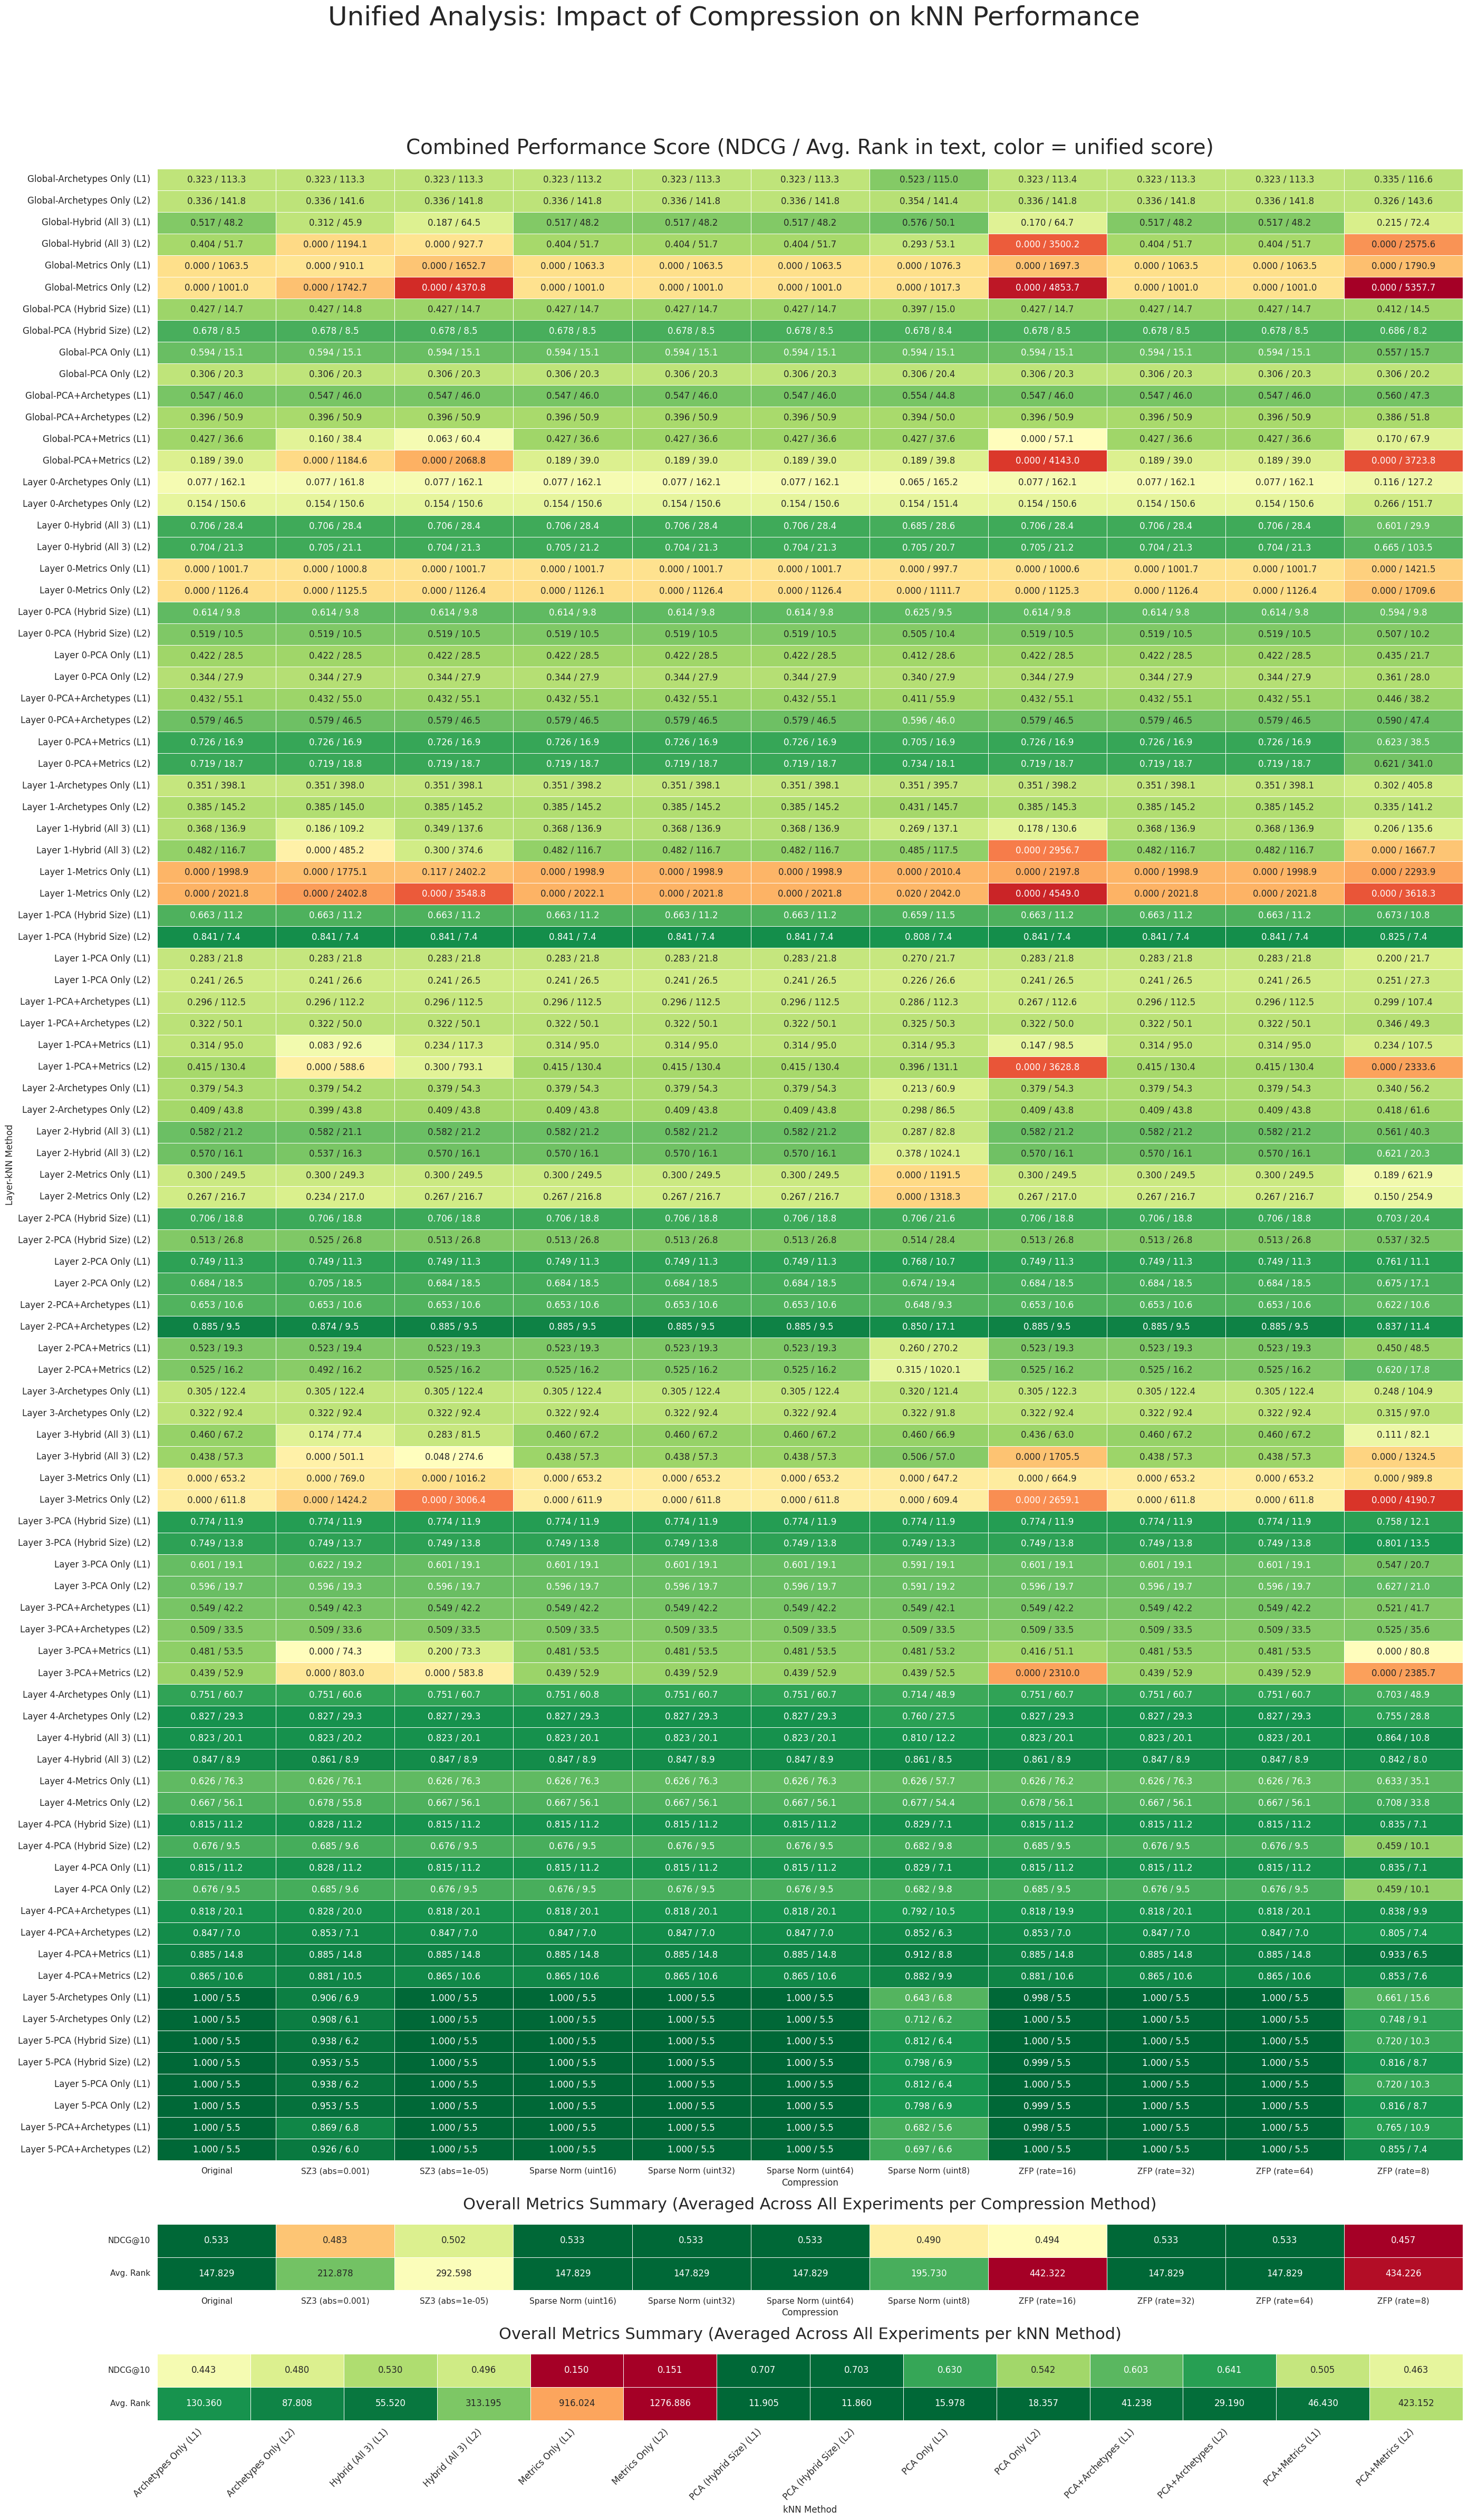

In [ ]:
# @title Influence on KNN after Compression { display-mode: "form" }

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import skew, kurtosis, entropy, rankdata
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import time
import os
import sys
import warnings
import scipy.sparse as sp

# Suppress known warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Precision loss occurred in moment calculation")
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Installation & Imports (Assuming successful execution from previous steps) ---
try:
    import zfpy
    print("Successfully imported zfpy.")
except ImportError:
    zfpy = None
    print("Warning: zfpy not found.")
try:
    from pysz import SZ
    pysz_compressor = SZ()
    print("Successfully imported pysz (for SZ3).")
except ImportError:
    pysz_compressor = None
    print("Warning: pysz not found.")

# --- Helper Functions ---
def _normalize_safe(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0: return np.array([])
    min_val = np.min(arr)
    shifted_arr = np.maximum(0.0, arr - min_val) + 1e-10
    arr_sum = np.sum(shifted_arr)
    if arr_sum < 1e-10:
        return np.full(arr.shape, 1.0 / arr.size) if arr.size > 0 else np.array([])
    else:
        return shifted_arr / arr_sum

def normalize_to_integer_sparse(sparse_data_coo, min_val, max_val, dtype=np.uint32):
    iinfo = np.iinfo(dtype)
    min_int, max_int = iinfo.min, iinfo.max
    if min_val == max_val:
        mid_int_val = min_int + (max_int - min_int) // 2
        return sp.coo_matrix((np.full_like(sparse_data_coo.data, mid_int_val, dtype=dtype),
                               (sparse_data_coo.row, sparse_data_coo.col)), shape=sparse_data_coo.shape)
    min_val_ld, max_val_ld = np.longdouble(min_val), np.longdouble(max_val)
    data_ld = sparse_data_coo.data.astype(np.longdouble)
    scale_factor = (np.longdouble(max_int) - np.longdouble(min_int)) / (max_val_ld - min_val_ld)
    shift_factor = np.longdouble(min_int) - min_val_ld * scale_factor
    normalized_data = data_ld * scale_factor + shift_factor
    normalized_data = np.clip(np.round(normalized_data), min_int, max_int).astype(dtype)
    return sp.coo_matrix((normalized_data, (sparse_data_coo.row, sparse_data_coo.col)), shape=sparse_data_coo.shape)

def reconstruct_from_normalized(sparse_int_coo, min_val, max_val, dtype=np.uint32):
    iinfo = np.iinfo(dtype)
    min_int, max_int = iinfo.min, iinfo.max
    if min_val == max_val:
        return sp.coo_matrix((np.full_like(sparse_int_coo.data, min_val, dtype=float), (sparse_int_coo.row, sparse_int_coo.col)), shape=sparse_int_coo.shape)
    min_val_ld, max_val_ld = np.longdouble(min_val), np.longdouble(max_val)
    data_ld = sparse_int_coo.astype(np.longdouble).data
    scale_factor = (max_val_ld - min_val_ld) / (np.longdouble(max_int) - np.longdouble(min_int))
    shift_factor = min_val_ld - np.longdouble(min_int) * scale_factor
    reconstructed_data = data_ld * scale_factor + shift_factor
    return sp.coo_matrix((reconstructed_data.astype(np.float64), (sparse_int_coo.row, sparse_int_coo.col)), shape=sparse_int_coo.shape)

def create_true_intrinsic_representative(vector):
    vector = np.asarray(vector, dtype=float)
    if vector.size < 2: return np.full(11, np.nan)
    return np.array([
        np.mean(vector), np.std(vector), skew(vector), kurtosis(vector),
        np.linalg.norm(vector, ord=2), np.linalg.norm(vector, ord=1),
        np.count_nonzero(np.abs(vector) > 1e-6) / vector.size,
        np.linalg.norm(vector, ord=1) / (np.linalg.norm(vector, ord=2) + 1e-9),
        np.ptp(vector), np.percentile(vector, 75) - np.percentile(vector, 25),
        np.median(vector)
    ])

def DIEM_Stat_Optimized(N, maxV, minV, num_iterations=1000):
    """Calculates the statistics needed to normalize Euclidean distances."""
    a_vectors = (maxV - minV) * np.random.rand(N, num_iterations) + minV
    b_vectors = (maxV - minV) * np.random.rand(N, num_iterations) + minV
    d = np.linalg.norm(a_vectors - b_vectors, axis=0)
    exp_center = np.median(d)
    vard = np.var(d)
    return exp_center, (vard if vard > 1e-9 else 1e-9)

def getDIEM_scores(target_vector, comparison_vectors, maxV, minV, exp_center, vard):
    """Calculates the DIEM scores between a target and a set of other vectors."""
    target_vector = np.atleast_2d(target_vector)
    comparison_vectors = np.atleast_2d(comparison_vectors)
    raw_dist = cdist(target_vector, comparison_vectors, metric='euclidean').flatten()
    DIEM_scores = (maxV - minV) * (raw_dist - exp_center) / vard
    return DIEM_scores

def calculate_average_rank(ground_truth_indices, predicted_ranking, k=K):
    true_top_k = ground_truth_indices[:k]
    rank_map = {sample_idx: rank + 1 for rank, sample_idx in enumerate(predicted_ranking)}
    return np.mean([rank_map.get(idx, len(predicted_ranking)) for idx in true_top_k])

def calculate_ndcg(ground_truth_indices, predicted_indices, k=K):
    relevance_map = {idx: k - i for i, idx in enumerate(ground_truth_indices[:k])}
    dcg = sum(relevance_map.get(pred_idx, 0) / np.log2(i + 2) for i, pred_idx in enumerate(predicted_indices[:k]))
    idcg = sum(relevance_map.get(gt_idx, 0) / np.log2(i + 2) for i, gt_idx in enumerate(ground_truth_indices[:k]))
    return dcg / (idcg + 1e-9)

# --- Core Analysis Functions ---

def get_reconstructed_datasets(original_data, scope_name, dtypes_to_test=[np.uint8, np.uint16, np.uint32, np.uint64]):
    """Compresses and decompresses data using all methods, returns a dict of reconstructed arrays."""
    print(f"--- Generating reconstructed datasets for {scope_name} ---")
    reconstructed_datasets = {'Original': original_data}
    original_data = original_data.astype(np.float64)
    # Correctly handle shapes for per-layer and global data
    is_global = original_data.ndim == 2
    num_samples = original_data.shape[0] if is_global else original_data.shape[2]
    num_neurons = original_data.shape[1] if is_global else original_data.shape[0]

    # SOTA Near-Lossless
    if zfpy:
        for rate in [8, 16, 32, 64]:
            compressed = zfpy.compress_numpy(original_data.T if is_global else original_data, rate=rate)
            recon = zfpy.decompress_numpy(compressed)
            reconstructed_datasets[f'ZFP (rate={rate})'] = recon.T if is_global else recon
    if pysz_compressor:
        for error_bound in [1e-3, 1e-5]:
            # pysz expects C-contiguous array
            data_to_compress = np.ascontiguousarray(original_data.T if is_global else original_data)
            compressed, _ = pysz_compressor.compress(data_to_compress, eb_mode=0, eb_abs=error_bound, eb_rel=0, eb_pwr=0)
            recon = pysz_compressor.decompress(compressed, data_to_compress.shape, data_to_compress.dtype)
            reconstructed_datasets[f'SZ3 (abs={error_bound})'] = recon.T if is_global else recon

    # Custom Sparse Norm
    original_data_transposed = original_data.T if original_data.ndim > 2 else original_data
    for dtype in dtypes_to_test:
        dtype_name = np.dtype(dtype).name
        method_name = f'Sparse Norm ({dtype_name})'
        reconstructed_data = []
        for i in range(num_samples):
            sample_vector = original_data_transposed[i, :]
            sparse_sample = sp.coo_matrix(sample_vector.reshape(-1, 1))
            if sparse_sample.nnz > 0:
                min_v, max_v = sparse_sample.min(), sparse_sample.max()
                sparse_int = normalize_to_integer_sparse(sparse_sample, min_v, max_v, dtype=dtype)
                reconstructed_sparse = reconstruct_from_normalized(
                    sp.coo_matrix((sparse_int.data, (sparse_int.row, np.zeros_like(sparse_int.row))), shape=(num_neurons, 1)), min_v, max_v, dtype=dtype)
                reconstructed_data.append(reconstructed_sparse.toarray())
            else:
                reconstructed_data.append(np.zeros((num_neurons, 1)))
        reconstructed_matrix = np.hstack(reconstructed_data)
        reconstructed_datasets[method_name] = reconstructed_matrix if original_data.ndim > 2 else reconstructed_matrix.T

    return reconstructed_datasets

def run_kNN_analysis_on_dataset(train_samples, target_sample, scope_name, compression_method, k=K):
    """Runs the full kNN ablation study on a single (potentially reconstructed) dataset."""
    results = []
    n_components = min(k, train_samples.shape[1] - 1)
    if n_components < 2: return [] # Not enough features for PCA/KMeans

    # --- 1. Calculate All Ground Truth Rankings ---
    gt_l1 = np.argsort(np.sum(np.abs(target_sample - train_samples), axis=1))
    gt_l2 = np.argsort(np.linalg.norm(target_sample - train_samples, axis=1))

    # Calculate DIEM ground truth - Excluded, because DIEM and Euclidean are identical in same dimension comparison
    # minV, maxV = train_samples.min(), train_samples.max()
    # exp_center, vard = DIEM_Stat_Optimized(train_samples.shape[1], maxV, minV)
    # diem_scores_gt = getDIEM_scores(target_sample, train_samples, maxV, minV, exp_center, vard)
    # gt_diem = np.argsort(diem_scores_gt)

    gts = {'L1': gt_l1, 'L2': gt_l2}#, 'DIEM': gt_diem}

    # Generate representatives
    reps_pca_train = PCA(n_components=n_components).fit_transform(train_samples)
    rep_pca_eval = PCA(n_components=n_components).fit(train_samples).transform(target_sample.reshape(1, -1))
    kmeans = MiniBatchKMeans(n_clusters=n_components, random_state=42, n_init='auto').fit(train_samples)
    archetypes = kmeans.cluster_centers_
    reps_arch_train = np.array([np.linalg.norm(s - archetypes, axis=1) for s in train_samples])
    rep_arch_eval = np.linalg.norm(target_sample - archetypes, axis=1).reshape(1, -1)
    reps_metric_train = np.array([create_true_intrinsic_representative(s) for s in train_samples])
    rep_metric_eval = create_true_intrinsic_representative(target_sample).reshape(1, -1)

    combined_length = (n_components*2 + create_true_intrinsic_representative(train_samples[0]).size)
    combined_length = combined_length if n_components >= k else n_components
    reps_pca_combined_train = PCA(n_components=combined_length).fit_transform(train_samples)
    rep_pca_combined_eval = PCA(n_components=combined_length).fit(train_samples).transform(target_sample.reshape(1, -1))

    configs = {
        "Metrics Only": (reps_metric_train, rep_metric_eval),
        "Archetypes Only": (reps_arch_train, rep_arch_eval),
        "PCA Only": (reps_pca_train, rep_pca_eval),
        "PCA (Hybrid Size)": (reps_pca_combined_train, rep_pca_combined_eval),
        "PCA+Metrics": (np.hstack([reps_metric_train, reps_pca_train]),
                           np.hstack([rep_metric_eval, rep_pca_eval])),
        "PCA+Archetypes": (np.hstack([reps_arch_train, reps_pca_train]),
                           np.hstack([rep_arch_eval, rep_pca_eval])),
        "Hybrid (All 3)": (np.hstack([reps_metric_train, reps_arch_train, reps_pca_train]),
                           np.hstack([rep_metric_eval, rep_arch_eval, rep_pca_eval]))
    }

    for name, (train_reps, eval_rep) in configs.items():
        if np.isnan(train_reps).any() or np.isnan(eval_rep).any(): continue
        scaler = StandardScaler().fit(train_reps)
        std_train = scaler.transform(train_reps)
        std_eval = scaler.transform(eval_rep)
        # Calculate distances for the representative space
        l1_dists = np.sum(np.abs(std_eval - std_train), axis=1)
        l2_dists = np.linalg.norm(std_eval - std_train, axis=1)

        # Also get DIEM distances for the representative space
        minV_rep, maxV_rep = train_reps.min(), train_reps.max()
        exp_center_rep, vard_rep = DIEM_Stat_Optimized(train_reps.shape[1], maxV_rep, minV_rep)
        diem_dists = getDIEM_scores(std_eval.squeeze(), std_train, maxV_rep, minV_rep, exp_center_rep, vard_rep)

        # Evaluate against all three ground truths
        for gt_name, gt_ranking in gts.items():
            for dist_type, dists in [('L1', l1_dists), ('L2', l2_dists)]:#, ('DIEM', diem_dists)]:
                if(dist_type == gt_name):
                    dists = rankdata(dists)
                    pred_ranking = np.argsort(dists)
                    results.append({
                        'Layer': scope_name,
                        'Compression': compression_method,
                        'kNN Method': f'{name} ({dist_type})',
                        f'NDCG@{K}': calculate_ndcg(gt_ranking, pred_ranking, k),
                        'Avg. Rank': calculate_average_rank(gt_ranking, pred_ranking, k)
                    })
    return results

def plot_final_heatmap_report(df):
    try:
        ndcg_pivot = df.pivot_table(index=['Layer', 'kNN Method'], columns='Compression', values=f'NDCG@{K}')
        rank_pivot = df.pivot_table(index=['Layer', 'kNN Method'], columns='Compression', values='Avg. Rank')
    except Exception as e:
        print(f"Could not create pivot tables. Error: {e}")
        return

    # --- Normalize ---
    min_ndcg, max_ndcg = ndcg_pivot.min().min(), ndcg_pivot.max().max()
    ndcg_range = max_ndcg - min_ndcg
    normalized_ndcg = (ndcg_pivot - min_ndcg) / ndcg_range if ndcg_range > 1e-9 else pd.DataFrame(1.0, index=ndcg_pivot.index, columns=ndcg_pivot.columns)

    min_rank, max_rank = rank_pivot.min().min(), rank_pivot.max().max()
    rank_range = max_rank - min_rank
    normalized_rank = (max_rank - rank_pivot) / rank_range if rank_range > 1e-9 else pd.DataFrame(1.0, index=rank_pivot.index, columns=rank_pivot.columns)

    combined_score_df = (normalized_ndcg + normalized_rank) / 2

    # Annotation labels
    annot_labels = pd.DataFrame(index=ndcg_pivot.index, columns=ndcg_pivot.columns, dtype=str)
    for col in ndcg_pivot.columns:
        for idx in ndcg_pivot.index:
            annot_labels.loc[idx, col] = f"{ndcg_pivot.loc[idx, col]:.3f} / {rank_pivot.loc[idx, col]:.1f}"

    # --- Existing summary per compression method ---
    summary_df = df.groupby('Compression')[[f'NDCG@{K}', 'Avg. Rank']].mean().T

    summary_norm_df = summary_df.copy()
    for metric in summary_norm_df.index:   # normalize row-wise
        min_val, max_val = summary_norm_df.loc[metric].min(), summary_norm_df.loc[metric].max()
        if (max_val - min_val) > 1e-9:
            summary_norm_df.loc[metric] = (summary_norm_df.loc[metric] - min_val) / (max_val - min_val)
        else:
            summary_norm_df.loc[metric] = 0.5

    # Invert "lower-is-better" metrics
    if 'Avg. Rank' in summary_norm_df.index:
        summary_norm_df.loc['Avg. Rank'] = 1 - summary_norm_df.loc['Avg. Rank']


    # --- Summary per kNN method ---
    summary_knn_df = df.groupby('kNN Method')[[f'NDCG@{K}', 'Avg. Rank']].mean().T

    summary_norm_knn_df = summary_knn_df.copy()
    for metric in summary_norm_knn_df.index:   # normalize row-wise
        min_val, max_val = summary_norm_knn_df.loc[metric].min(), summary_norm_knn_df.loc[metric].max()
        if (max_val - min_val) > 1e-9:
            summary_norm_knn_df.loc[metric] = (summary_norm_knn_df.loc[metric] - min_val) / (max_val - min_val)
        else:
            summary_norm_knn_df.loc[metric] = 0.5

    # Invert "lower-is-better" metrics
    if 'Avg. Rank' in summary_norm_knn_df.index:
        summary_norm_knn_df.loc['Avg. Rank'] = 1 - summary_norm_knn_df.loc['Avg. Rank']

    # --- Plot ---
    fig, axes = plt.subplots(3, 1, figsize=(28, 48), gridspec_kw={'height_ratios': [30, 1, 1]})
    fig.suptitle('Unified Analysis: Impact of Compression on kNN Performance', fontsize=36, y=0.995)

    # Heatmap with combined score
    sns.heatmap(
        combined_score_df,
        ax=axes[0],
        annot=annot_labels,
        fmt="s",
        cmap="RdYlGn",
        linewidths=.5,
        vmin=0, vmax=1,
        cbar=False
    )
    axes[0].set_title('Combined Performance Score (NDCG / Avg. Rank in text, color = unified score)', fontsize=28, pad=20)
    axes[0].tick_params(axis='y', rotation=0, labelsize=12)
    #plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=12)

    # Summary per compression
    sns.heatmap(summary_norm_df, ax=axes[1], annot=summary_df, fmt='.3f', cmap='RdYlGn', cbar=False, linewidths=.5)
    axes[1].set_title('Overall Metrics Summary (Averaged Across All Experiments per Compression Method)', fontsize=22, pad=20)

    # Summary per kNN method
    sns.heatmap(summary_norm_knn_df, ax=axes[2], annot=summary_knn_df, fmt='.3f', cmap='RdYlGn', cbar=False, linewidths=.5)
    axes[2].set_title('Overall Metrics Summary (Averaged Across All Experiments per kNN Method)', fontsize=22, pad=20)
    plt.setp(axes[2].get_xticklabels(), rotation=45, ha='right', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Main Orchestrator ---
if __name__ == '__main__':
    all_final_results = []

    # Per-Layer Analysis
    for i in range(len(layerSizes)):
        layer_data = activationsBySources[i, :layerSizes[i], :]
        eval_sample_data = evaluation_activations[i, :layerSizes[i], EVAL_SAMPLE_TO_CHECK]

        reconstructed_train_sets = get_reconstructed_datasets(layer_data, f'Layer {i}')
        # Reconstruct the single eval sample
        eval_sample_shaped = eval_sample_data.reshape(layerSizes[i], 1)
        reconstructed_eval_sets = get_reconstructed_datasets(eval_sample_shaped, f'Eval Sample Layer {i}')

        for compression_name, recon_train_data in reconstructed_train_sets.items():
            if compression_name in reconstructed_eval_sets:
                train_recon = recon_train_data.T # Shape to (samples, features)
                eval_recon = reconstructed_eval_sets[compression_name].T.squeeze()

                results = run_kNN_analysis_on_dataset(train_recon, eval_recon, f'Layer {i}', compression_name)
                all_final_results.extend(results)

    # Global Analysis
    def create_global_super_vectors(activations, layer_sizes):
        num_samples = activations.shape[2]
        all_samples_global = [np.concatenate([activations[l, :layer_sizes[l], s] for l in range(len(layer_sizes))]) for s in range(num_samples)]
        return np.array(all_samples_global)

    train_super_vectors = create_global_super_vectors(activationsBySources, layerSizes)
    eval_super_vectors = create_global_super_vectors(evaluation_activations, layerSizes)

    reconstructed_train_global = get_reconstructed_datasets(train_super_vectors, 'Global')
    reconstructed_eval_global = get_reconstructed_datasets(eval_super_vectors[EVAL_SAMPLE_TO_CHECK].reshape(1, -1), 'Global Eval Sample')

    for compression_name, recon_train_data in reconstructed_train_global.items():
        if compression_name in reconstructed_eval_global:
            eval_recon_global = reconstructed_eval_global[compression_name]

            results = run_kNN_analysis_on_dataset(recon_train_data, eval_recon_global.squeeze(), 'Global', compression_name)
            all_final_results.extend(results)

    results_df = pd.DataFrame(all_final_results)

    #print("\n--- Final Summary Table (NDCG@10 Scores for L2 distance) ---")
    #df_l2 = results_df[results_df['kNN Method'].str.contains('(L2)')].copy()
    #df_l2['kNN Method'] = df_l2['kNN Method'].str.replace(' \(L2\)', '')
    #print(df_l2.pivot_table(index=['Layer', 'kNN Method'], columns='Compression', values=f'NDCG@{K}').round(4))

    plot_final_heatmap_report(results_df)

In [ ]:
# @title Storage of the results { display-mode: "form" }

joblib.dump(all_final_results, 'compression_results_knn.joblib')
print("Results successfully saved to compression_results_knn.joblib")

# Load the data from the file
resultsArrayKNN = joblib.load('compression_results_knn.joblib')

# You can now use this loaded variable for analysis or visualization
print("Successfully loaded results.")
print(f"Loaded data for {len(all_final_results)} compression methods.")

Results successfully saved to compression_results_knn.joblib
Successfully loaded results.
Loaded data for 1012 compression methods.
